<a href="https://colab.research.google.com/github/jiyoon-park97/AIFFEL_quest_cr/blob/main/Ex03_Portrait_M1_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

전체코드를 보시길 원하신다면  
https://www.notion.so/modulabs/M1-1d55c8e5427d807aa852e888cc75b93b  
노션페이지를 참조해주세요!

## 개요  
1. 다른 이미지 파일로 쉘로우 포커스 만들기  
  1.1 도마뱀  
  1.2 현정님 사진  
    (1) 인물은 원본으로 유지하고 배경만 블러 처리  
    (2) 배경을 다른 이미지로 교체하는 크로마키 효과  
  1.3 트롤 인형
2. 다른 모델을 써가며 쉘로우 포커스 만들기
  Deeplabv3_resnet101  
  Deeplab-xception  
  SAM  
  FBA Matting
3. 플러터
4. 회고  
- 배운 점
- 아쉬운 점
- 느낀 점
- 어려웠던 점

### 1. 다른 이미지 파일로 쉘로우 포커스 만들기

#### 1.1 도마뱀

In [ ]:
# 1. 필요한 라이브러리 설치
!pip install -q transformers accelerate torch torchvision

# 2. 라이브러리 임포트
from transformers import OneFormerProcessor, OneFormerForUniversalSegmentation
from PIL import Image
import requests
import matplotlib.pyplot as plt
import torch

# 3. 모델과 프로세서 로드
processor = OneFormerProcessor.from_pretrained("shi-labs/oneformer_coco_swin_large")
model = OneFormerForUniversalSegmentation.from_pretrained("shi-labs/oneformer_coco_swin_large")

# 4. 이미지 불러오기
image = Image.open("/content/aiffel/human_segmentation/images/test_gecko1.jpg").convert("RGB")

# 5. 입력 전처리
inputs = processor(images=image, task_inputs=["semantic"], return_tensors="pt")

# 6. 모델 추론
with torch.no_grad():
    outputs = model(**inputs)

# 7. 결과 후처리
segmentation = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]

# 8. 시각화
plt.figure(figsize=(10, 10))
plt.imshow(segmentation, cmap="jet")
plt.axis("off")
plt.title("OneFormer 세그멘테이션 결과")
plt.show()



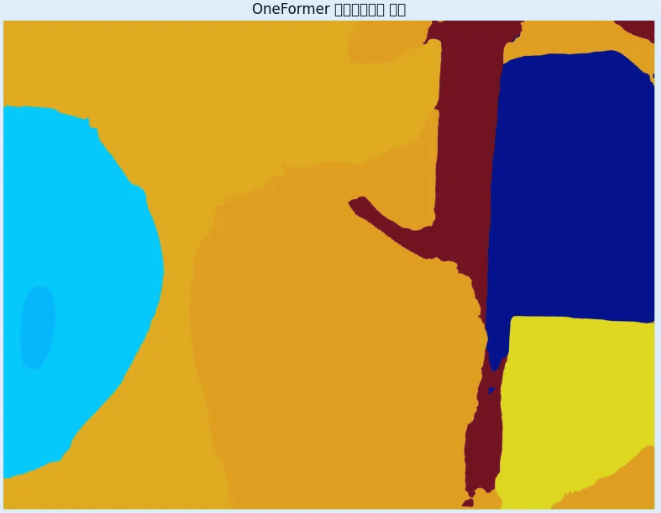

In [ ]:

# 1. PIL 이미지를 OpenCV용 BGR로 변환
img_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

# 2. segmentation을 numpy mask로 변환
mask_np = np.array(segmentation)

# 3. 가장 큰 객체(class) 하나만 선택해서 마스크 생성
#   (여러 클래스가 있을 경우, 도마뱀처럼 보이는 애를 기준으로 수동 지정해도 됨)
#   여기선 그냥 "사람이 아닌 영역은 배경"이라고 가정
#   foreground = 객체, background = 나머지

# 예시: 가장 많이 나온 클래스 ID 하나 추출
main_class = np.bincount(mask_np.flatten()).argmax()
object_mask = (mask_np == main_class).astype(np.uint8) * 255

# 4. 객체 마스크의 반대편 = 배경
background_mask = cv2.bitwise_not(object_mask)

# 5. 블러 처리된 이미지 만들기
blurred_img = cv2.GaussianBlur(img_cv, (55, 55), 0)

# 6. 마스크 3채널로 확장
object_mask_3ch = cv2.merge([object_mask]*3)
background_mask_3ch = cv2.merge([background_mask]*3)

# 7. 각각의 마스크를 적용하여 원본과 블러 이미지 분리
foreground = cv2.bitwise_and(img_cv, object_mask_3ch)
background = cv2.bitwise_and(blurred_img, background_mask_3ch)

# 8. 둘을 합성
final = cv2.add(foreground, background)

# 9. 시각화
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(final, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("OneFormer + 배경 블러")
plt.show()

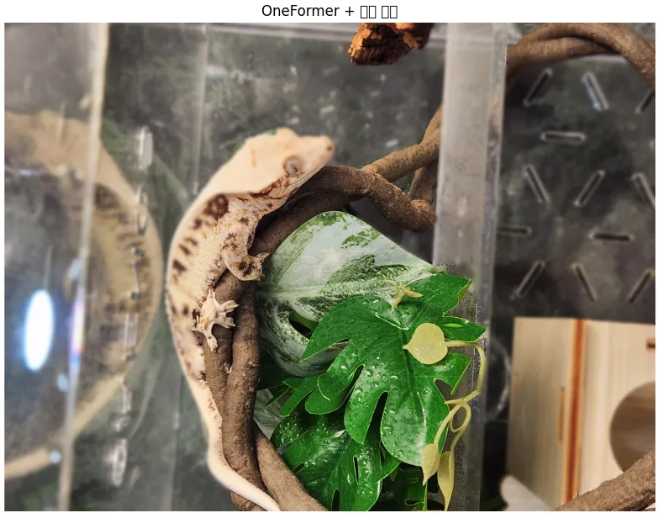

🎯 목적  
	• 도마뱀을 정확히 잘라내고  
	•	배경은 흐리게  

✅ 결론
OneFormer 는 가장큰 비중을 차지하는 클래스 중심으로 마스크 생성
-> 도마뱀이라는 객체 자체를 인지못함
-> 배경으로 처리됨
  
💬 한 줄 요약:
도마뱀 분리 정확도 + 배경 블러만 원한다면 → SAM이 훨씬 낫다.
클릭 없이 자동 마스크 추출도 가능해서 훨씬 깔끔하게 자를 수 있음.

#### 1.2 현정님 사진

(1) 인물은 원본으로 유지하고 배경만 블러 처리

100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 190GB/s]


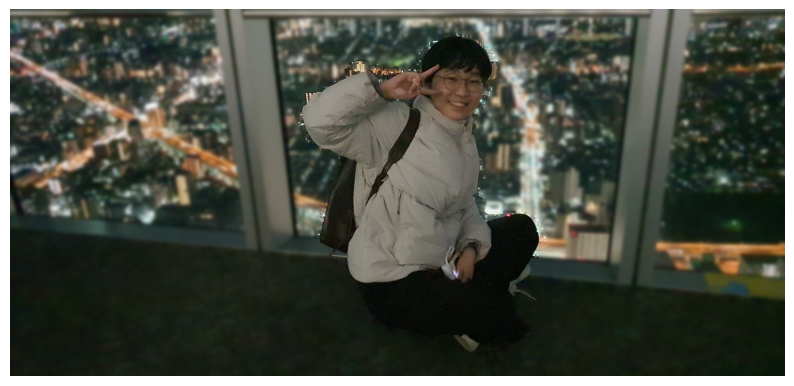

In [ ]:
from rembg import remove
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# 1. 이미지 불러오기
img_path = '/content/aiffel/human_segmentation/images/my_image1.jpg'
img = Image.open(img_path)
img_np = np.array(img)

# 2. 배경 제거 및 마스크 얻기
output = remove(img)
# 알파 채널(마스크) 추출
if output.mode == 'RGBA':
    mask = np.array(output)[:, :, 3]
else:
    # RGBA가 아닌 경우 처리
    rgba = output.convert('RGBA')
    mask = np.array(rgba)[:, :, 3]

# 마스크를 이진화: 0 또는 255로 구성
mask_binary = np.where(mask > 0, 255, 0).astype(np.uint8)

# 3. OpenCV 형식으로 원본 이미지 변환 (RGB -> BGR)
img_cv = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

# 4. 배경 블러 처리
blurred = cv2.GaussianBlur(img_cv, (55, 55), 0)

# 5. 마스크를 3채널로 확장 (BGR 각 채널에 동일한 마스크 적용)
mask_3channel = cv2.merge([mask_binary, mask_binary, mask_binary])

# 6. 마스크를 사용하여 원본과 블러 이미지 합성
# 마스크 값이 255인 부분(인물)은 원본 이미지, 0인 부분(배경)은 블러 이미지
final = np.where(mask_3channel > 0, img_cv, blurred)

# 7. 시각화 (BGR -> RGB 변환하여 출력)
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(final, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

**✅** 깔끔하게 블러처리가 되는 상황은 아닌 것으로 보임!

(2) 배경을 다른 이미지로 교체하는 크로마키 효과

인물 이미지 크기: 3000 x 4000
조정된 배경 이미지 크기: 3000 x 4000


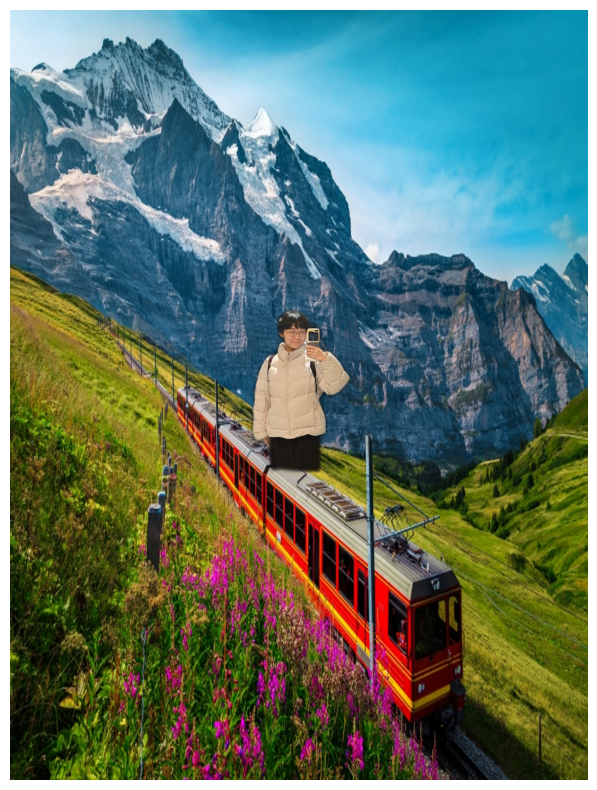

In [ ]:
from rembg import remove
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# 1. 인물 이미지와 새 배경 이미지 불러오기
person_img_path = '/content/aiffel/human_segmentation/images/my_image2.jpg'
new_bg_path = '/content/aiffel/human_segmentation/images/background.jpg'

person_img = Image.open(person_img_path)
new_bg_img = Image.open(new_bg_path)

# 2. 배경 제거하여 인물만 추출
output = remove(person_img)
output_np = np.array(output)

# 인물 이미지 크기 확인
person_height, person_width = output_np.shape[0], output_np.shape[1]
print(f"인물 이미지 크기: {person_width} x {person_height}")

# 3. 새 배경 이미지를 인물 이미지와 '정확히 같은 크기'로 조정
new_bg_img = new_bg_img.resize((person_width, person_height))
new_bg_np = np.array(new_bg_img)
print(f"조정된 배경 이미지 크기: {new_bg_np.shape[1]} x {new_bg_np.shape[0]}")

# 4. 알파 마스크 추출
if output_np.shape[2] == 4:  # RGBA 확인
    alpha = output_np[:, :, 3] / 255.0
    alpha = np.stack([alpha, alpha, alpha], axis=2)

    # 5. 합성 (알파 블렌딩)
    foreground = output_np[:, :, :3]
    composite = foreground * alpha + new_bg_np * (1 - alpha)
    composite = composite.astype(np.uint8)

    # 6. 결과 시각화
    plt.figure(figsize=(10, 10))
    plt.imshow(composite)
    plt.axis('off')
    plt.show()

✅ 한번 창문에 비치는 배경만 바꿀 수는 없을까? 하는 고민에 아래처럼 재시도

#### 1.3 트롤 인형

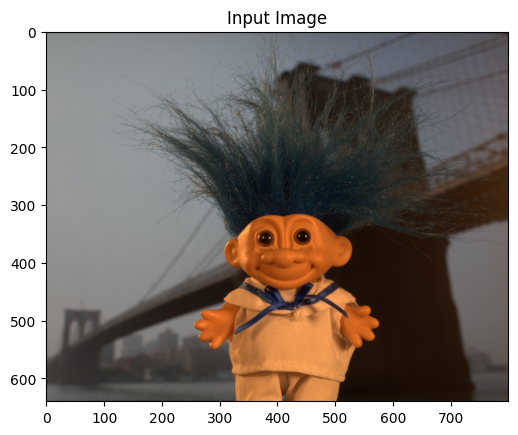

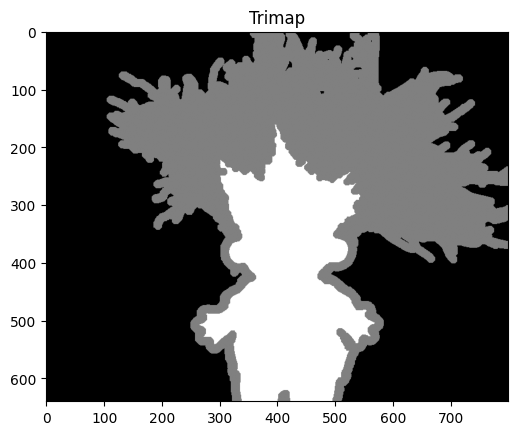

In [ ]:
plt.title('Input Image')
plt.imshow(image)
plt.show()

# transform two channel trimap back to single channel
trimap_im =  trimap[:,:,1] + (1-np.sum(trimap,-1))/2
plt.title('Trimap')
plt.imshow(trimap_im, cmap='gray', vmin=0, vmax=1)
plt.show()

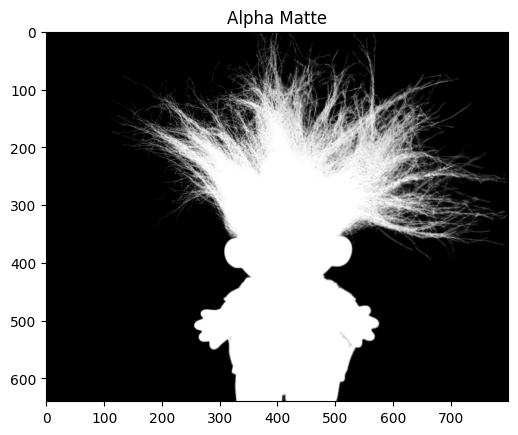

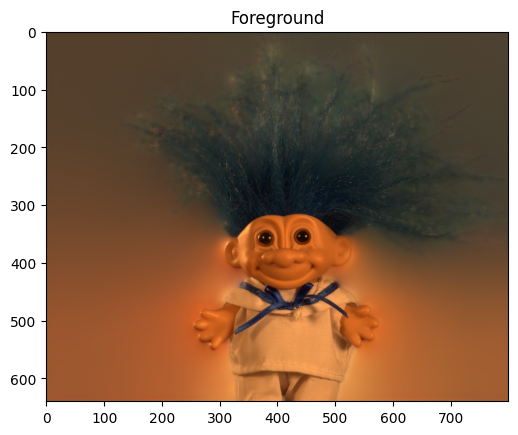

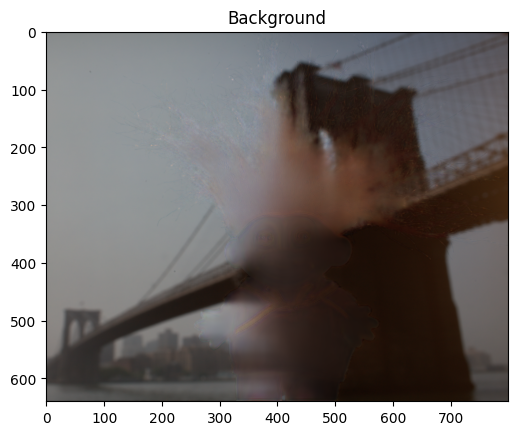

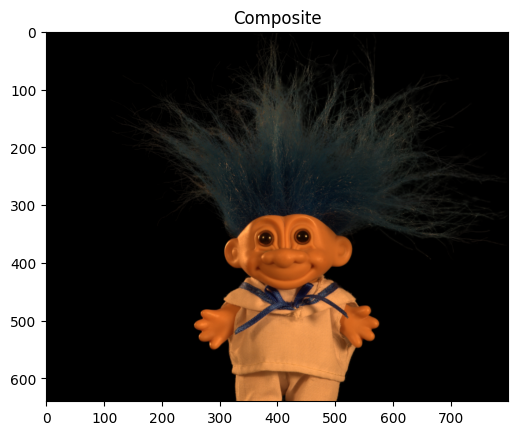

In [ ]:
plt.title('Alpha Matte')
plt.imshow(alpha, cmap='gray', vmin=0, vmax=1)
plt.show()
plt.title('Foreground')
plt.imshow(fg)
plt.show()
plt.title('Background')
plt.imshow(bg)
plt.show()
plt.title('Composite')
plt.imshow(fg*alpha[:,:,None])
plt.show()

### 2. 다른 모델을 써가며 쉘로우 포커스 만들기

Deeplabv3_resnet101  
✅ 배경에 옷이 남아있음 <-- 문제

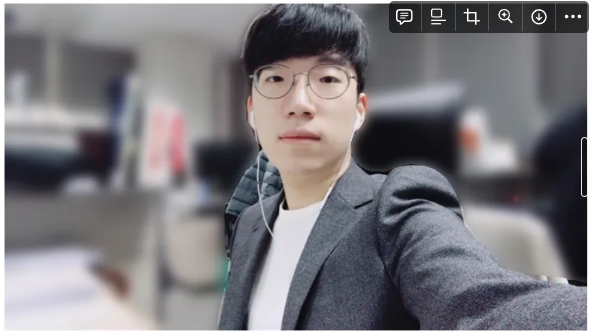

Deeplab-xception  
✅ 배경에 옷이 여전히 남아있음  
✅ person mask에 옷이 포함되어 있음  
--> 시그멘테이션을 더 잘 할 수 있는 모델이 필요

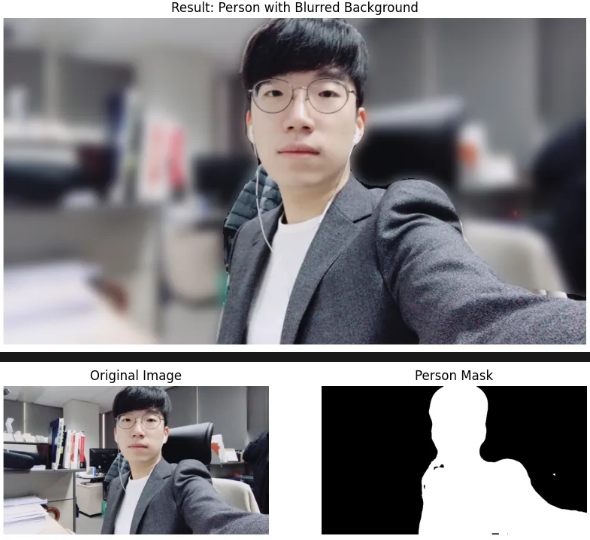

SAM(Segment Anything Model)  
- Meta는 2023년 4월, 이미지 분할 모델인 **SAM(Segment Anything Model)** 발표함
- SAM은 **한 번의 클릭만으로 이미지 내 어떤 객체도 분할**할 수 있음
- 기존 방식과 달리 **작업자 개입 없이 자동 분할 가능**하며, **Zero-Shot 추론**도 지원함

In [ ]:
# ============================================
# 1. Segment Anything 설치 & 모델 가중치 다운로드
# ============================================
!pip install git+https://github.com/facebookresearch/segment-anything.git opencv-python matplotlib pillow
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

# ============================================
# 2. 필요한 라이브러리 임포트
# ============================================
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# segment-anything 레포지토리에서 제공하는 모듈들
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# ============================================
# 3. SAM 모델 준비
# - Vit-H 버전 예시 (sam_vit_h_4b8939.pth)
# ============================================
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to('cuda' if torch.cuda.is_available() else 'cpu')

# 자동으로 모든 객체를 분할해주는 Mask Generator
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_batch=64,      # 자동 마스킹 시 생성할 포인트 수
    pred_iou_thresh=0.9,      # 예측 마스크 품질 기준
    stability_score_thresh=0.9,
    min_mask_region_area=1000 # 마스크 최소 면적
)

# ============================================
# 4. 이미지 불러오기
# ============================================
user_image_path = "/content/drive/MyDrive/aiffel/human_segmentation/my_image.png"
img_pil = Image.open(user_image_path).convert("RGB")
img_np = np.array(img_pil)  # (H, W, 3) in RGB

# SAM은 numpy 배열(RGB) 사용
height, width, _ = img_np.shape

# ============================================
# 5. 자동 마스크 생성
# ============================================
masks = mask_generator.generate(img_np)
# masks는 [{'segmentation': ndarray(H,W), 'area': ..., 'bbox': ..., ...}, ...]

# ============================================
# 6. 가장 넓은 면적(=가장 큰 객체) 마스크 하나 고르기 (인물이라고 가정)
# ============================================
if len(masks) == 0:
    print("No mask found. Please try another image or adjust mask_generator settings.")
    exit()

# area 기준으로 최대값 찾기
largest_mask = max(masks, key=lambda x: x['area'])
mask_person = largest_mask['segmentation'].astype(np.uint8)  # (H, W)

# SAM의 mask는 True/False로 구성될 수 있으므로 1/0 => 255/0 변환
mask_person = np.where(mask_person > 0, 255, 0).astype(np.uint8)

# ============================================
# 7. 배경 블러 처리
# ============================================
# OpenCV 포맷(BGR)으로 변환
img_cv = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

# 배경 블러 (커널 크기 조정 가능)
blurred = cv2.GaussianBlur(img_cv, (55, 55), 0)

# 마스크를 3채널로 확장
mask_3channel = cv2.merge([mask_person, mask_person, mask_person])

# 마스크가 255인 부분(=인물)은 원본, 0인 부분(=배경)은 블러 적용
final = np.where(mask_3channel > 0, img_cv, blurred)

# ============================================
# 8. 결과 시각화
# ============================================
plt.figure(figsize=(10,10))
# BGR -> RGB
plt.imshow(cv2.cvtColor(final, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


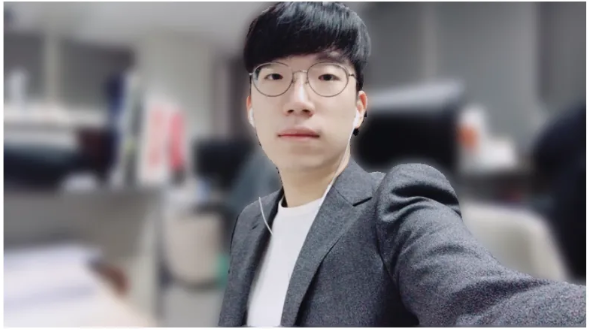

✅ 옷 지우는데 성공  
✅ 선이 같이 지워짐

FBA Matting

✅이미지 매팅에 특화된 모델로, 전경과 배경 사이의 경계를 부드럽게 처리하는 알파 마스크를 만듦. 이미지 원본만이 아니라, Trimap(전경, 배경, 불확실 영역을 표시한 맵)을 입력으로 사용함. Trimap 퀄리티가 중요해보임.

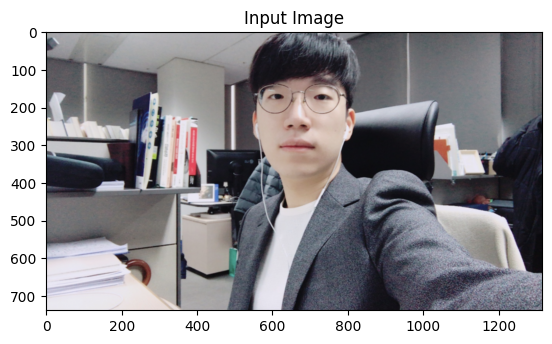

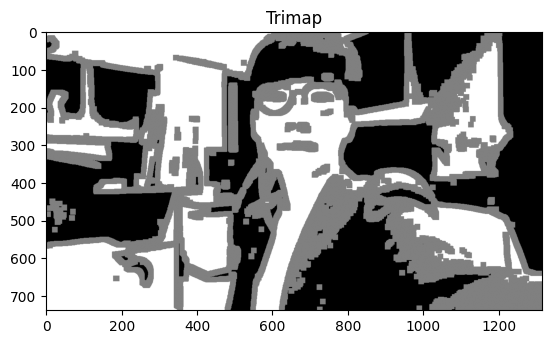

In [ ]:
plt.title('Input Image')
plt.imshow(image)
plt.show()

# transform two channel trimap back to single channel
trimap_im =  trimap[:,:,1] + (1-np.sum(trimap,-1))/2
plt.title('Trimap')
plt.imshow(trimap_im, cmap='gray', vmin=0, vmax=1)
plt.show()

Alpha Matte, Foreground, Background, Composite

✅Alpha Matte 알파 매트

이 알파 마스크는 배경 블러 처리에서 "어디가 인물이고 어디가 배경인지" 구분하는 데 사용됩니다.

✅Foreground 전경

원본 이미지에서 추출한 순수한 전경(인물) 부분입니다(매팅된 전경)

✅Background 배경

모델이 추출한 순수한 배경 부분입니다. 인물이 제거된 이미지입니다.

✅Composite 합성

알파마스크를 전경에 적용한 결과입니다(선명한 인물과 블러된 배경을 합성)




이런 방식으로 인물은 그대로 선명하게 유지하면서 배경만 흐릿하게 처리하는 효과를 얻을 수 있습니다.

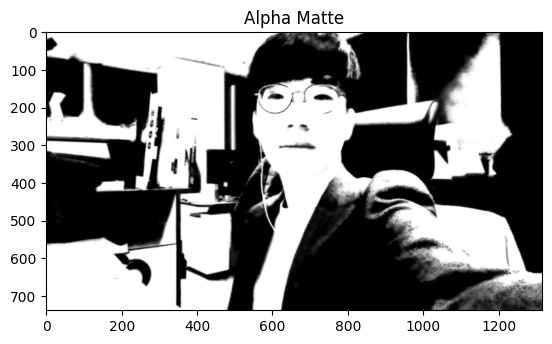

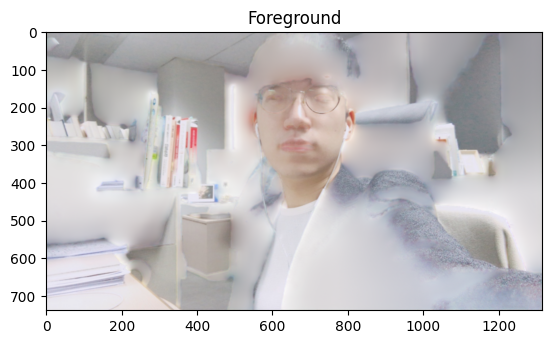

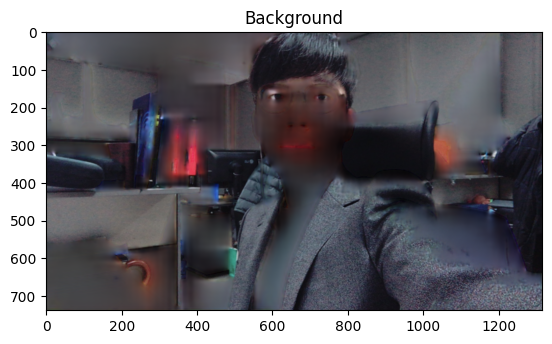

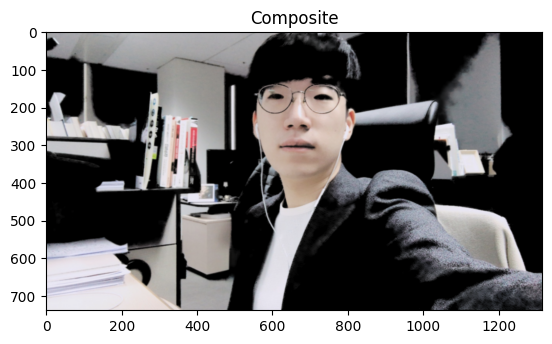

In [ ]:
plt.title('Alpha Matte')
plt.imshow(alpha, cmap='gray', vmin=0, vmax=1)
plt.show()
plt.title('Foreground')
plt.imshow(fg)
plt.show()
plt.title('Background')
plt.imshow(bg)
plt.show()
plt.title('Composite')
plt.imshow(fg*alpha[:,:,None])
plt.show()

✅하지만 trimap의 조잡함 때문인지 FBA Matting이 제기능을 못하고 있는 것으로 보임. 인물하고 배경을 제대로 구분하지 못함. 섬세한 모델이기는 해서 이어폰도 잘 살리고 있는데 사람 눈동자가 사라져서 최종 결과물이 너무 무서움..

### 3. 플러터


In [ ]:
import 'package:flutter/material.dart';
import 'package:http/http.dart' as http;
import 'dart:typed_data';
import 'package:image_picker/image_picker.dart';

void main() {
  runApp(MaterialApp(
    home: BlurApp(),
    debugShowCheckedModeBanner: false,
  ));
}

class BlurApp extends StatefulWidget {
  @override
  _BlurAppState createState() => _BlurAppState();
}

class _BlurAppState extends State<BlurApp> {
  Uint8List? imageBytes;
  bool isLoading = false;

  Future<void> sendImageToServer() async {
    final picker = ImagePicker();
    final pickedFile = await picker.pickImage(source: ImageSource.gallery);

    if (pickedFile == null) return;

    setState(() {
      isLoading = true;
    });

    var request = http.MultipartRequest(
      'POST',
      Uri.parse('https://urlurlurl~~~~~~.ngrok-free.app/blur_background'), // 여기에 ngrok 주소!
    );

    request.files.add(await http.MultipartFile.fromPath('image', pickedFile.path));

    var response = await request.send();
    print("응답 코드: ${response.statusCode}");

    if (response.statusCode == 200) {
      final data = await response.stream.toBytes();
      setState(() {
        imageBytes = data;
        isLoading = false;
      });
    } else {
      print("이미지 처리 실패");
      setState(() async {
        isLoading = false;

        print("서버에 요청 보냄");
        var response = await request.send();
        print("응답 코드: ${response.statusCode}");

        if (response.statusCode == 200) {
          final data = await response.stream.toBytes();
          print("받은 데이터 길이: ${data.length}");

          setState(() {
            imageBytes = data;
            isLoading = false;
          });
        } else {
          print("서버 응답 실패: ${response.statusCode}");
          setState(() {
            isLoading = false;
          });
        }
      });
    }
  }

  @override
  Widget build(BuildContext context) {
    return Scaffold(
      appBar: AppBar(title: Text("🖼 배경 블러 앱")),
      body: Center(
        child: isLoading
            ? CircularProgressIndicator()
            : imageBytes != null
            ? Image.memory(imageBytes!)
            : Text("사진을 선택해보세요 🥺"),
      ),
      floatingActionButton: FloatingActionButton(
        onPressed: sendImageToServer,
        child: Icon(Icons.upload),
        tooltip: "사진 업로드",
      ),
    );
  }
}




### 4. 회고

배운 점

- 다양한 방식으로 인물과 배경을 분리하는 시도 경험
- FBA Matting처럼 정밀한 경계 분리가 가능한 모델 학습
- 블러 처리 및 시각적 효과에 대한 이해
- 이미지 분할 성능 향상을 위한 모델 탐색 과정 경험

아쉬운 점

- 깔끔한 인물 분리에 실패한 사례 다수
- 조잡한 trimap 때문에 FBA Matting 성능 제대로 발휘 못함
- 플러터 구현에서 성능과 자유도 부족
- 기대한 수준의 앱까지 도달하지 못함

느낀 점

- 이미지 작업은 어렵지만 흥미롭고 즐거움도 있었음
- 나와 관련된 데이터를 활용한 실험이 유익하고 재미있었음
- 성능 좋은 모델을 만든 개발자들에 대한 존경심

어려웠던 점

- 인물과 배경 색상 유사 시 분리 어려움
- 이어폰처럼 가늘고 작은 객체는 분리에 어려움
- 정밀한 trimap 작성이 까다로움
- 플러터 개발 과정에서 인내심을 많이 소모함